In [17]:
%%bash
tree -d /kaggle/input/flowers-recognition/

/kaggle/input/flowers-recognition/
└── flowers
    ├── daisy
    ├── dandelion
    ├── rose
    ├── sunflower
    └── tulip

6 directories


In [18]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [19]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.7.0
DEVICE: cuda


In [20]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [21]:
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [22]:
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

flowers_ds = CustomDataset(
    list_images=glob.glob("/kaggle/input/flowers-recognition/flowers/*/*.jpg"),
    transform=custom_transform
)

### Visualise the data pipeline

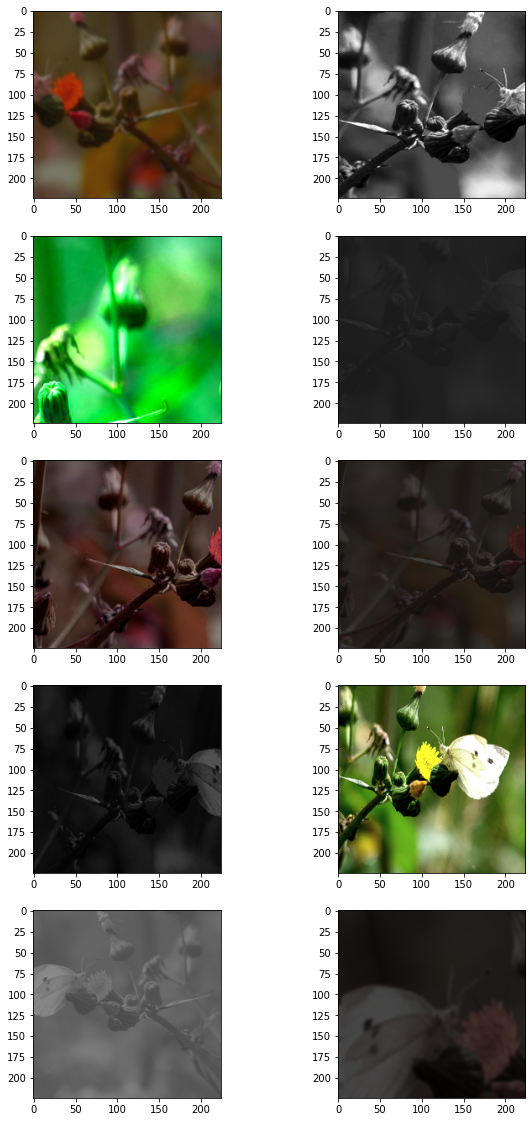

In [23]:
plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(flowers_ds,200)

In [24]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [25]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

In [26]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [27]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

In [28]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 0.7517 
EPOCH: 1 BATCH: 20 LOSS: 0.5468 
EPOCH: 1 BATCH: 30 LOSS: 0.5395 
Time taken: 2.144 mins
EPOCH: 2 BATCH: 10 LOSS: 0.5368 
EPOCH: 2 BATCH: 20 LOSS: 0.5359 
EPOCH: 2 BATCH: 30 LOSS: 0.5336 
Time taken: 2.055 mins
EPOCH: 3 BATCH: 10 LOSS: 0.5257 
EPOCH: 3 BATCH: 20 LOSS: 0.5279 
EPOCH: 3 BATCH: 30 LOSS: 0.5243 
Time taken: 2.022 mins
EPOCH: 4 BATCH: 10 LOSS: 0.5235 
EPOCH: 4 BATCH: 20 LOSS: 0.5171 
EPOCH: 4 BATCH: 30 LOSS: 0.5223 
Time taken: 1.989 mins
EPOCH: 5 BATCH: 10 LOSS: 0.5165 
EPOCH: 5 BATCH: 20 LOSS: 0.5162 
EPOCH: 5 BATCH: 30 LOSS: 0.5083 
Time taken: 2.025 mins
EPOCH: 6 BATCH: 10 LOSS: 0.5008 
EPOCH: 6 BATCH: 20 LOSS: 0.5027 
EPOCH: 6 BATCH: 30 LOSS: 0.5074 
Time taken: 1.996 mins
EPOCH: 7 BATCH: 10 LOSS: 0.5066 
EPOCH: 7 BATCH: 20 LOSS: 0.4882 
EPOCH: 7 BATCH: 30 LOSS: 0.4962 
Time taken: 1.996 mins
EPOCH: 8 BATCH: 10 LOSS: 0.4878 
EPOCH: 8 BATCH: 20 LOSS: 0.4869 
EPOCH: 8 BATCH: 30 LOSS: 0.4815 
Time taken: 2.077 mins
EPOCH: 9 BATCH: 10 LOSS:

In [29]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)

In [31]:
resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

flowers_ds = ImageFolder(
    root="/kaggle/input/flowers-recognition/flowers/",
    transform=custom_transform
)

nu_classes = len(flowers_ds.classes)

BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [33]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(512, nu_classes)
    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding) 
        return pred

In [34]:
eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters())

In [35]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(train_dl):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = eval_model(image)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 0.1608 
EPOCH: 1 BATCH: 20 LOSS: 0.1426 
EPOCH: 1 BATCH: 30 LOSS: 0.1381 
Time taken: 0.162 mins
EPOCH: 2 BATCH: 10 LOSS: 0.1327 
EPOCH: 2 BATCH: 20 LOSS: 0.1296 
EPOCH: 2 BATCH: 30 LOSS: 0.1270 
Time taken: 0.162 mins
EPOCH: 3 BATCH: 10 LOSS: 0.1263 
EPOCH: 3 BATCH: 20 LOSS: 0.1245 
EPOCH: 3 BATCH: 30 LOSS: 0.1226 
Time taken: 0.167 mins
EPOCH: 4 BATCH: 10 LOSS: 0.1209 
EPOCH: 4 BATCH: 20 LOSS: 0.1195 
EPOCH: 4 BATCH: 30 LOSS: 0.1241 
Time taken: 0.162 mins
EPOCH: 5 BATCH: 10 LOSS: 0.1193 
EPOCH: 5 BATCH: 20 LOSS: 0.1205 
EPOCH: 5 BATCH: 30 LOSS: 0.1196 
Time taken: 0.162 mins
EPOCH: 6 BATCH: 10 LOSS: 0.1170 
EPOCH: 6 BATCH: 20 LOSS: 0.1209 
EPOCH: 6 BATCH: 30 LOSS: 0.1184 
Time taken: 0.162 mins
EPOCH: 7 BATCH: 10 LOSS: 0.1178 
EPOCH: 7 BATCH: 20 LOSS: 0.1166 
EPOCH: 7 BATCH: 30 LOSS: 0.1173 
Time taken: 0.173 mins
EPOCH: 8 BATCH: 10 LOSS: 0.1176 
EPOCH: 8 BATCH: 20 LOSS: 0.1196 
EPOCH: 8 BATCH: 30 LOSS: 0.1185 
Time taken: 0.169 mins
EPOCH: 9 BATCH: 10 LOSS: